In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import Libraries

# System
import gc
import shutil
import time
import glob
import logging

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import random
import cv2
from tqdm import tqdm
tqdm.pandas()

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image, display, HTML
# Machine Learning
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torchvision.utils import save_image
import math
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import cv2

In [3]:
logging.basicConfig(
    filename='log.txt',  # Log file name
    level=logging.INFO,            # Log level
    format='%(asctime)s - %(levelname)s - %(message)s'  # Log format
)

In [4]:
BASE_PATH = "/kaggle/input/dlp-course-depth-estimation-challenge/competition-data/competition-data/"

In [5]:
train_images=os.listdir(BASE_PATH+"training/images")
train_depths = []

for i in range(len(train_images)):
    train_depths.append(BASE_PATH+"training/depths/"+train_images[i])
    train_images[i] = BASE_PATH+"training/images/"+train_images[i]
    


val_images=os.listdir(BASE_PATH+"validation/images")
val_depths = []
for i in range(len(val_images)):
    val_depths.append(BASE_PATH+"validation/depths/"+val_images[i])
    val_images[i] = BASE_PATH+"validation/images/"+val_images[i]
    

test_images=os.listdir(BASE_PATH+"testing/images")
for i in range(len(val_images)):
    test_images[i] = BASE_PATH+"testing/images/"+test_images[i]

train_df = pd.DataFrame({"image": train_images, "depth": train_depths})
val_df = pd.DataFrame({"image": val_images, "depth": val_depths})
test_df = pd.DataFrame({"image": test_images})

In [6]:
train_df.to_csv("df_train.csv", index=False)
val_df.to_csv("df_val.csv", index=False)
test_df.to_csv("df_test.csv", index=False)

In [7]:
# train_df = pd.read_csv("/kaggle/working/df_train.csv")
# val_df = pd.read_csv("/kaggle/working/df_val.csv")
# test_df = pd.read_csv("/kaggle/working/df_test.csv")

In [8]:
val_df.head(5)

,image,depth
0,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
1,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
2,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
3,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
4,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...


In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        #channels: 3->64,
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 64->128
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 128->256
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels: 256->512
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv8 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #channels:512->1024
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        self.upconv1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        #channels:1024->512
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv12 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.upconv2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        #channels: 512->256
        self.conv13 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv14 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        self.upconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        #channels:256->128
        self.conv15 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv16 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.upconv4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        #channels:128->64
        self.conv17 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv18 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        #channels:64->1
        self.conv19 = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1, padding = 0)

        #relu: for non-linearity relu(x)=max(0,x)
        self.relu = nn.ReLU()
        #group_normalisation
        self.gn1 = nn.GroupNorm(16, 64)
        self.gn2 = nn.GroupNorm(16, 128)
        self.gn3 = nn.GroupNorm(16, 256)
        self.gn4 = nn.GroupNorm(16, 512)
        self.gn5 = nn.GroupNorm(16, 1024)
        #drop out layers; set the fraction of neurons to 0
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.gn1(x)
        x = self.relu(x)
        out1 = x
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.gn2(x)
        x = self.relu(x)
        out2 = x
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.gn3(x)
        x = self.relu(x)
        out3 = x
        x = self.maxpool3(x)
        x = self.dropout(x)
        x = self.conv7(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.gn4(x)
        x = self.relu(x)
        out4 = x
        x = self.maxpool4(x)
        x = self.dropout(x)
        x = self.conv9(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.upconv1(x)
        x = torch.cat((x, out4), 1)
        x = self.dropout(x)
        x = self.conv11(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.upconv2(x)
        x = torch.cat((x, out3), 1)
        x = self.dropout(x)
        x = self.conv13(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv14(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.upconv3(x)
        x = torch.cat((x, out2), 1)
        x = self.dropout(x)
        x = self.conv15(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv16(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.upconv4(x)
        x = torch.cat((x, out1), 1)
        x = self.dropout(x)
        x = self.conv17(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv18(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv19(x)
        x = torch.nn.functional.sigmoid(x) #since depth is between 0-1
        return x


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def minmaxscaler(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [11]:
def depth_statistics(image_path):
    img = cv2.imread(image_path)
    depth_range = img.max() - img.min()
    mean = np.mean(img)
    std = np.std(img)
    return depth_range, mean, std

In [12]:
# train_df["depth_range"], train_df["mean"], train_df["std"] = zip(*train_df['depth'].progress_apply(depth_statistics))
# val_df["depth_range"], val_df["mean"], val_df["std"] = zip(*val_df['depth'].progress_apply(depth_statistics))

train_df.head(5)

,image,depth
0,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
1,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
2,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
3,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...
4,/kaggle/input/dlp-course-depth-estimation-chal...,/kaggle/input/dlp-course-depth-estimation-chal...


In [13]:
class CLAHETransform():
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), hist_equalize=True):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.hist_equalize=hist_equalize
        
    def __call__(self, image):
        image_np = np.array(image)

        # Convert to grayscale if the image is in color
        if image_np.ndim == 3:
            gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        else:
            gray_image = image_np
            
        if self.hist_equalize:
            # Step 3: Apply histogram equalization
            gray_image = cv2.equalizeHist(gray_image)
        
        # Step 4: Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_image = clahe.apply(gray_image)
        
        # Step 5: Convert back to RGB
        clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

        # Convert NumPy array back to PIL Image
        return Image.fromarray(clahe_image_rgb)

In [14]:
def show_clahe_image(image_path):
    # view clahe image

    original_image = Image.open(image_path)
    
    # Create an instance of CLAHETransform
    clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8), hist_equalize=False)
    
    # Apply the CLAHE transformation
    clahe_image = clahe_transform(original_image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('CLAHE Image')
    plt.imshow(clahe_image)
    plt.axis('off')
    plt.show()

In [15]:
class DepthDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
                            CLAHETransform(),
                            transforms.Resize((264, 264)),
                            transforms.CenterCrop((256, 256)),
                            transforms.ToTensor(),                # Convert the images to tensors
                            transforms.Normalize(                 # Normalize with ImageNet statistics
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                            ),
                        ])
        self.depthtransform = transforms.Compose([
                            transforms.Resize((264, 264)),
                            transforms.CenterCrop((256, 256)),
                            transforms.ToTensor(),                # Convert the images to tensors
                        ])
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        rgb_image = Image.open(img_path).convert("RGB")
        if self.transform:
            rgb_image = self.transform(rgb_image)

        
        if "testing" in img_path:
            return rgb_image, img_path.split("/")[-1]
            
        depth_path = self.dataframe.iloc[idx]['depth']
        depth_image = Image.open(depth_path).convert("L")  # Assuming depth is single-channel
        if self.transform:
            depth_image = self.depthtransform(depth_image)
            depth_image = (depth_image - torch.min(depth_image)) / (torch.max(depth_image) - torch.min(depth_image))
            
        return rgb_image, depth_image


In [16]:
depth_dataset = DepthDataset(val_df)

In [17]:
image=depth_dataset[5][0]

In [18]:
def transform_show(image):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    # Denormalize the image
    denormalized_image = image * std[:, None, None] + mean[:, None, None]
    
    # Clip the values to be in the range [0, 1]
    denormalized_image = torch.clamp(denormalized_image, 0, 1)
    
    # Convert to NumPy array and transpose to (H, W, C)
    denormalized_image_np = denormalized_image.permute(1, 2, 0).numpy()
    
    # Visualize the transformed image
    plt.figure(figsize=(5, 5))
    plt.imshow(denormalized_image_np)
    plt.axis('off')  # Hide axes
    plt.title('Transformed Image with CLAHE')
    plt.show()

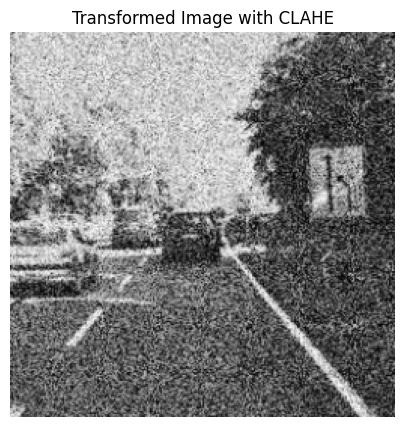

In [19]:
transform_show(image)

In [20]:
train_dataset=DepthDataset(dataframe=train_df)
val_dataset=DepthDataset(dataframe=val_df)
test_dataset=DepthDataset(dataframe=test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False,num_workers=2)

In [21]:
def rmse_loss(y_true, y_pred):
    rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
    return rmse

In [23]:
def loss_function(y_true, y_pred):
    l_depth = torch.mean(torch.abs(y_pred - y_true))
    l_mse = torch.mean(torch.abs(y_pred - y_true)**2)
    w2, w3 = 1.0, 10.0
    return (w3 * l_depth) + (w2 * l_mse)

In [24]:
def load_model(model_path, model, optimizer):
    # best_valid_loss = float('inf')
    if os.path.isfile(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        stats = {"epoch": epoch}
        try:
            stats["val_loss"]=checkpoint["val_loss"]
            stats["train_loss"]=checkpoint["train_loss"]
        except:
            pass
        # best_valid_loss = checkpoint['loss']
    else:
        print("No existing weights found")
    return model, optimizer, stats

In [34]:
model = UNet().to(device)
lr = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr)

{'epoch': 27}

In [35]:
# unet with adam: first 27 epochs at lr 0.0003, next 50 at lr 0.0001

In [36]:
%mkdir train val
# %rm -r train/

mkdir: cannot create directory 'train': File exists
mkdir: cannot create directory 'val': File exists


In [37]:
def train(dataset, epoch, device=device):
    train_loss_batch = []
    train_rmse_loss = []
    model.train()

    for idx,(images, labels) in enumerate(dataset):
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        output = model(images)
        train_loss = loss_function(labels, output)
        train_rmse_loss.append(rmse_loss(labels, output).item())
        train_loss_batch.append(train_loss)
        # output = torch.round(output)
        if idx % 100 == 0:
            print(f"Batch: {idx + 1}   Train Loss: {train_loss}")
        if idx % 100 == 0:
            one_width = output.shape[3]
            total_width = one_width * 3
            new_image = Image.new('RGB', (total_width, output.shape[2]))
            # Paste the images into the new image
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(images[0].permute(1, 2, 0).detach().cpu().numpy())*255.)), (0, 0))
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(labels[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width, 0))
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(output[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width*2, 0))
            new_image.save(f"train/combined_image_e{epoch}_{idx+1}.png")
        # Backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_loss = sum(train_loss_batch)/len(dataset)
    print(f"Train Epoch Loss: {train_loss}")
    rmse_los = sum(train_rmse_loss)/len(dataset)
    return train_loss, rmse_los
    

def validate(dataset, epoch, device=device):
    val_loss_batch = []
    val_rmse_loss = []
    model.eval()
    with torch.no_grad():
        for idx,(images, labels) in enumerate(dataset):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            val_loss = loss_function(labels, output)
            val_loss_batch.append(val_loss)
            val_rmse_loss.append(rmse_loss(labels, output).item())
            if idx % 100 == 0:
                one_width = output.shape[3]
                total_width = one_width * 3
                new_image = Image.new('RGB', (total_width, output.shape[2]))

                # Paste the images into the new image
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(images[0].permute(1, 2, 0).detach().cpu().numpy())*255.)), (0, 0))
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(labels[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width, 0))
                new_image.paste(Image.fromarray(np.uint8(minmaxscaler(output[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (one_width*2, 0))
                new_image.save(f"val/combined_image_e{epoch}_{idx+1}.png")

    val_loss = sum(val_loss_batch)/len(dataset)
    print(f"Val Loss: {val_loss}")
    logging.info(f"Val Epoch: {epoch}, Loss: {val_loss}")
    rmse_los = sum(val_rmse_loss)/len(dataset)
    
    return val_loss, rmse_los


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [1]:
train_loss = []
val_loss = []
batch_size = 8
epochs = 77
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(epochs):
    start_time = time.monotonic()
    print(f"Epoch: {epoch + 1}")
    t_loss, t_rmse=train(train_loader, epoch)
    v_loss, v_rmse=validate(val_loader, epoch)
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    print(f"Epoch: {epoch}/{epochs}, train loss: {t_loss:.3f}, val loss: {v_loss:.3f}")
    print(f" RMSE: train: {t_rmse:.3f}, val: {v_rmse:.3f}")
    if epoch % 5 == 0:
        print("Saving...")
        torch.save({
                'epoch': epoch,
                'val_loss': v_loss,
                'train_loss': t_loss,
                'val_rmse': v_rmse,
                'train_rmse': t_rmse,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
        }, f"depth_estimation_{epoch}_adam.pt")
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\nTIME TAKEN FOR THE EPOCH: {} mins and {} seconds\n\n".format(epoch_mins, epoch_secs))
print("OVERALL TRAINING COMPLETE")

In [41]:
# final model save: checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, f"depth_estimation_f{epoch}_adam.pt"
)

In [4]:
x1 = [x.cpu().item() for x in train_loss]
x2 = [x.cpu().item() for x in val_loss]

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(1, epochs+1)), x1, label='Training Loss', marker='o')
plt.plot(list(range(1, epochs+1)), x2, label='Validation Loss', marker='o')

# Adding titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(list(range(1, epochs+1)))  # Set x-ticks to be the epoch numbers
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Prediction on Test Dataset

In [45]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [47]:
!mkdir -p data/predictions_1

In [48]:
predictions_folder = "data/predictions_1"

In [49]:
def predict(model, dataset, device=device):
    model.eval()
    with torch.no_grad():
        for idx,(image, img_name) in enumerate(dataset):
            print(img_name[0])
            output = model(image.to(device))
            one_width = output.shape[3]
            new_image = Image.new('L', (one_width, output.shape[2]))
            # Paste the images into the new image
            new_image.paste(Image.fromarray(np.uint8(minmaxscaler(output[0].repeat(3, 1, 1).permute(1, 2, 0).detach().cpu().numpy())*255.)), (0, 0))
            new_image.save(f"{predictions_folder}/{img_name[0]}")
    print("Done...")

In [50]:
predict(model, test_loader, device)

325652.png
8251652.png
18553711.png
41158232.png
11552312.png
27655531.png
37757551.png
29755951.png
11152231.png
16653331.png
29655931.png
22054411.png
255511.png
6851371.png
95192.png
425851.png
41358271.png
39657932.png
37157431.png
5051011.png
34756952.png
11652332.png
135271.png
511.png
6051211.png
32956592.png
27355471.png
35557111.png
455912.png
39257851.png
30756151.png
175351.png
5951192.png
15453091.png
5451092.png
13152632.png
34956991.png
39257852.png
5751151.png
7651532.png
17453491.png
7851571.png
7251451.png
9551912.png
31556311.png
26655331.png
17953591.png
14152831.png
14552912.png
36857372.png
39557912.png
31456292.png
14652932.png
37657532.png
39057812.png
41558311.png
105211.png
105212.png
1532.png
7751551.png
31256252.png
23854772.png
14452891.png
22554511.png
34456891.png
21154231.png
33956791.png
40558111.png
16153231.png
395791.png
20554112.png
22754551.png
5251051.png
8251651.png
205412.png
17253452.png
29355871.png
185372.png
425852.png
26555311.png
29155831.p

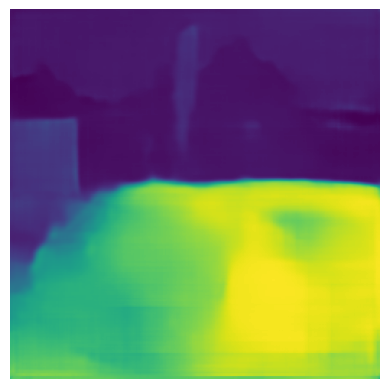

In [51]:
image = Image.open(f"{predictions_folder}/10452092.png")

# Display the image inline
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

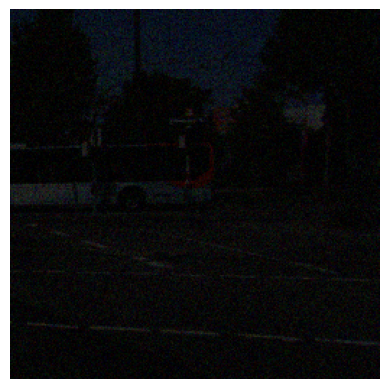

In [54]:
image = Image.open(BASE_PATH+"/testing/images/10452092.png")

# Display the image inline
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [55]:
import os
import cv2
import pandas as pd
import numpy as np

def images_to_csv_with_metadata(image_folder, output_csv):
    # Initialize an empty list to store image data and metadata
    data = []

    # Loop through all images in the folder
    for idx, filename in enumerate(sorted(os.listdir(image_folder))):
        if filename.endswith(".png"):
            filepath = os.path.join(image_folder, filename)
            # Read the image
            image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
            image = cv2.resize(image, (128, 128))
            image = image / 255.
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)
            image = np.uint8(image * 255.)
            # Flatten the image into a 1D array
            image_flat = image.flatten()
            # Add ID, ImageID (filename), and pixel values
            row = [idx, filename] + image_flat.tolist()
            data.append(row)
    
    # Create a DataFrame
    num_columns = len(data[0]) - 2 if data else 0
    column_names = ["id", "ImageID"] + [indx for indx in range(num_columns)]
    df = pd.DataFrame(data, columns=column_names)

    # Save to CSV
    df.to_csv(output_csv, index=False)


# Output CSV paths
predictions_csv = "predictions4.csv"

# Convert prediction images to CSV
images_to_csv_with_metadata(predictions_folder, predictions_csv)

In [48]:
ls -sh

total 11G
4.0K data/                   237M depth_estimation_35.pt
356M depth_estimation_10.pt  237M depth_estimation_36.pt
356M depth_estimation_11.pt  237M depth_estimation_37.pt
356M depth_estimation_12.pt  237M depth_estimation_38.pt
356M depth_estimation_13.pt  237M depth_estimation_39.pt
237M depth_estimation_14.pt  237M depth_estimation_40.pt
356M depth_estimation_15.pt  237M depth_estimation_41.pt
356M depth_estimation_16.pt  237M depth_estimation_42.pt
356M depth_estimation_17.pt  237M depth_estimation_43.pt
356M depth_estimation_18.pt  237M depth_estimation_44.pt
356M depth_estimation_19.pt  237M depth_estimation_45.pt
237M depth_estimation_20.pt  237M depth_estimation_46.pt
356M depth_estimation_21.pt  237M depth_estimation_47.pt
237M depth_estimation_22.pt  237M depth_estimation_48.pt
356M depth_estimation_23.pt  237M depth_estimation_49.pt
237M depth_estimation_24.pt  356M depth_estimation_f49.pt
237M depth_estimation_25.pt   96K df_test.csv
237M depth_estimation_26.pt  1.